In [192]:
import tensorflow as tf
import os
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
male_feature_path = './feature_data/all_male_feats.npy'
male_labels_path = './feature_data/all_male_labels.npy'
female_feature_path = './feature_data/all_female_feats.npy'
female_labels_path = './feature_data/all_female_labels.npy'

In [4]:
RAND_SEED = 231 # same data set as from training

In [58]:
male_feats = np.load(male_feature_path)
male_labels = np.load(male_labels_path)
female_feats = np.load(female_feature_path)
female_labels = np.load(female_labels_path)

feats = np.concatenate((male_feats, female_feats))
labels = np.concatenate((male_labels, female_labels))

np.random.seed(RAND_SEED)
shuf_inds = np.random.permutation(range(len(feats)))
feats = feats[shuf_inds]
labels = labels[shuf_inds]

feat_train, feat_test, label_train, label_test =  train_test_split(feats, labels, test_size = .3 , shuffle = False)
feat_val, feat_test, label_val, label_test = train_test_split(feat_test, label_test, test_size = .5, shuffle = False)
train_gt = np.argmax(label_train[:, :2], axis = 1)
val_gt = np.argmax(label_val[:, :2], axis = 1)
test_gt = np.argmax(label_test[:, :2], axis = 1)

In [13]:
model_file_path ='./model_1e-05_20_0.25/best_model/'
model_train_hist_path = './model_1e-05_20_0.25/loss_curves.pkl'
epoch_loss_history, val_loss_history, batch_loss_history = pickle.load(open(model_train_hist_path, 'rb'))

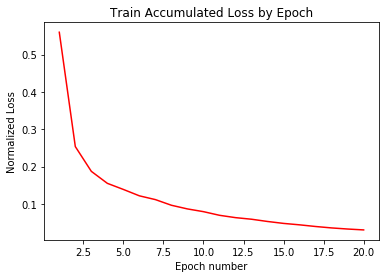

In [94]:
plt.plot(range(1, len(epoch_loss_history) + 1), np.array(epoch_loss_history), 'r')
plt.xlabel('Epoch number')
plt.ylabel('Normalized Loss')
plt.title('Train Accumulated Loss by Epoch')
plt.show()

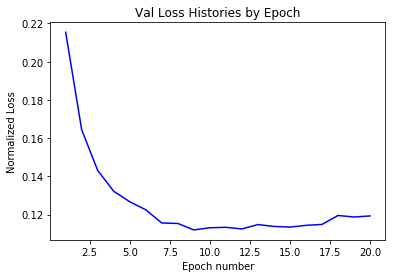

In [95]:
plt.plot(range(1, len(epoch_loss_history) + 1), np.array(val_loss_history), 'b')
plt.xlabel('Epoch number')
plt.ylabel('Normalized Loss')
plt.title('Val Loss Histories by Epoch')
plt.show()

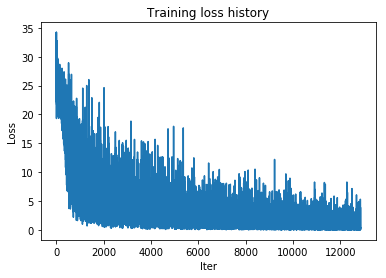

In [20]:
plt.plot(batch_loss_history)
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
"""Brief Discussion


Loss curves decaying nicely, seems that the model parameters have converged 
"""

In [48]:
input_tensor_name = 'inputs/Placeholder:0'
mode_tensor_name = 'inputs/mode:0'
prob_tensor_name = 'output/Softmax:0'

In [49]:
with tf.Session(graph=tf.Graph()) as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_file_path)
    input_tensor = sess.graph.get_tensor_by_name(input_tensor_name)
    mode_tensor = sess.graph.get_tensor_by_name(mode_tensor_name)
    softmax_tensor = sess.graph.get_tensor_by_name(prob_tensor_name)
    train_preds = np.argmax(sess.run(softmax_tensor, feed_dict = {input_tensor : feat_train, mode_tensor : False}), axis = 1)
    val_preds = np.argmax(sess.run(softmax_tensor, feed_dict = {input_tensor : feat_val, mode_tensor : False}), axis = 1)
    test_preds = np.argmax(sess.run(softmax_tensor, feed_dict = {input_tensor : feat_test, mode_tensor_name : False}), axis = 1)

INFO:tensorflow:Restoring parameters from ./model_1e-05_20_0.25/best_model/variables/variables


In [59]:
""" TRAIN ACC """



print("Train acc is ", np.mean(np.equal(train_preds,train_gt)))

Train acc is  0.9952438728463965


In [60]:
""" VAL ACC """




print("Val acc is ", np.mean(np.equal(val_preds, val_gt)))

Val acc is  0.9642210144927537


In [186]:
""" TEST ACC """



print("Test acc is ", np.mean(np.equal(test_preds, test_gt)))

Test acc is  0.9635416666666666


In [68]:
""" Error Analysis """
# Female labels are 1, male labels are 0
val_error_ages = label_val[np.invert(np.equal(val_preds, val_gt)), -1]
test_error_ages = label_test[np.invert(np.equal(test_preds, test_gt)), -1]

In [195]:
confusion_matrix(val_gt, val_preds) / len(val_gt)

array([[0.48845109, 0.01970109],
       [0.0160779 , 0.47576993]])

In [196]:
confusion_matrix(test_gt, test_preds) / len(test_preds)

array([[0.49773551, 0.01970109],
       [0.01675725, 0.46580616]])

In [ ]:
""" Brief discussion

Looks like the misclassification error rates are roughly equal between classes from the above confusion matrices.

"""

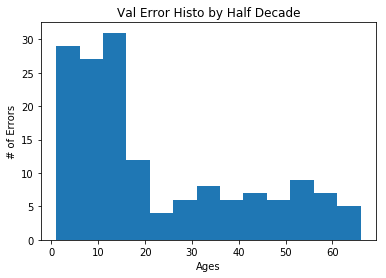

In [88]:
plt.hist(val_error_ages, bins = range(1, 71, 5))
plt.xlabel('Ages')
plt.ylabel('# of Errors')
plt.title('Val Error Histo by Half Decade')
plt.show()

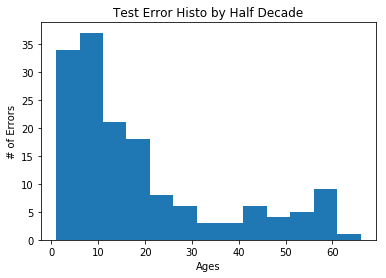

In [89]:
check = plt.hist(test_error_ages, bins = range(1, 71, 5))
plt.xlabel('Ages')
plt.ylabel('# of Errors')
plt.title('Test Error Histo by Half Decade')
plt.show()

In [ ]:
""" Brief discussion

These results make sense... young kids / babies have the fewest gender specific facial features! Not sure why the older
ages also are slightly higher... maybe from the wrinkles :) 

"""

In [ ]:
test_male_input_path = '../agegender_cleaned/combined/aligned/26_M/25337768_1987-07-15_2014.jpg'
test_fe_input_path = '../agegender_cleaned/combined/aligned/23_F/2449562_1981-07-29_2005.jpg'
fimg = scipy.ndimage.imread(test_fe_input_path)
fimg = scipy.misc.imresize(fimg, 1.75)
ftimg = np.expand_dims(fimg, 0)
mimg = scipy.ndimage.imread(test_male_input_path)
mimg = scipy.misc.imresize(mimg, 1.75)
mtimg = np.expand_dims(mimg, 0)

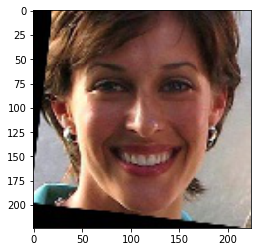

In [179]:
plt.imshow(fimg)
plt.show()

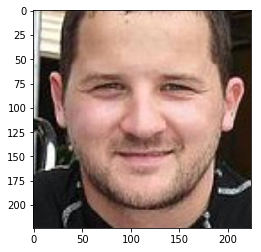

In [180]:
plt.imshow(mimg)
plt.show()

In [176]:
input_tensor_name = 'input:0'
feature_tensor_name = 'Flatten_2/flatten/Reshape:0'
feature_input_tensor_name = 'inputs/Placeholder:0'
mode_tensor_name = 'inputs/mode:0'
prob_tensor_name = 'output/Softmax:0'

In [182]:
""" TEST COMBINED MODEL """
vgg_model_path ='../tf_model_info/tf_out/'
gc_model_path ='./model_1e-05_20_0.25/best_model/'
with tf.Session(graph = tf.Graph()) as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.TRAINING], vgg_model_path)
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], gc_model_path)
    
    input_img_tensor = sess.graph.get_tensor_by_name(input_tensor_name)
    feature_tensor = sess.graph.get_tensor_by_name(feature_tensor_name)
    feature_input_tensor = sess.graph.get_tensor_by_name(feature_input_tensor_name)
    mode_tensor = sess.graph.get_tensor_by_name(mode_tensor_name)
    prob_tensor = sess.graph.get_tensor_by_name(prob_tensor_name)
    
    f_feats = sess.run(feature_tensor, feed_dict = {input_img_tensor : ftimg})
    m_feats = sess.run(feature_tensor, feed_dict = {input_img_tensor : mtimg})
    f_probs = sess.run(prob_tensor, feed_dict = {feature_input_tensor : f_feats, mode_tensor : False})
    m_probs = sess.run(prob_tensor, feed_dict = {feature_input_tensor : m_feats, mode_tensor : False})
    
    

INFO:tensorflow:Restoring parameters from ../tf_model_info/tf_out/variables/variables
INFO:tensorflow:Restoring parameters from ./model_1e-05_20_0.25/best_model/variables/variables


In [183]:
f_probs

array([[6.959068e-09, 1.000000e+00]], dtype=float32)

In [184]:
m_probs

array([[1.0000000e+00, 1.4546712e-09]], dtype=float32)

In [ ]:
"""Brief Discussion

Looks like for these two input images, the full model pipeline is quite confident that the
female image is a female, and the male image is a male. Looks good! 
"""